# Data paths to csv file


In [1]:
import os
import pandas as pd
import re
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import PIL.Image as Image
import matplotlib.pyplot as plt
# import cv2
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CyclicLR
#########################################################
from Data_Normalization import Call_Normalizer
from NetsArchNoDepth import loma_data,load_data,Net1,Net2,Net3,generate_csv
#########################################################

## Training datase dataloader

In [2]:

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Loading data

In [3]:
train_loader,test_loader,valid_loader =load_data()

Length of the train_loader: 485
Size of trainloader sampler 4841
Length of the test_loader: 303
Size of TestLoader sampler 1514
Length of the valid_loader: 243
Size of ValidLoader sampler 1211


In [4]:
# print(mean_rgb,mean_depth,std_RGB, std_Depth)
# tensor([0.5326, 0.5094, 0.5153]) tensor([3184.9036]) tensor([0.1806, 0.2050, 0.1970]) tensor([4051.8313])


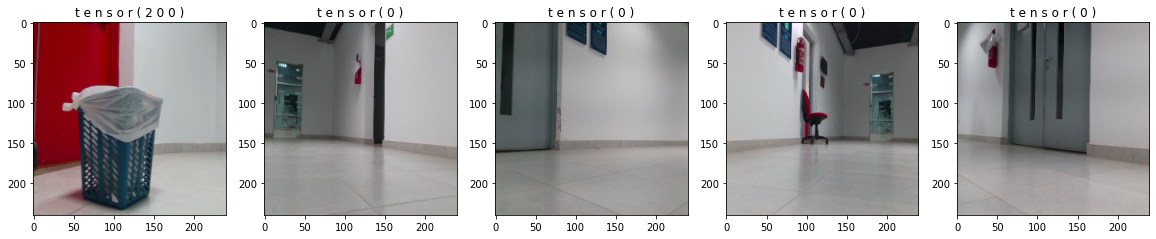

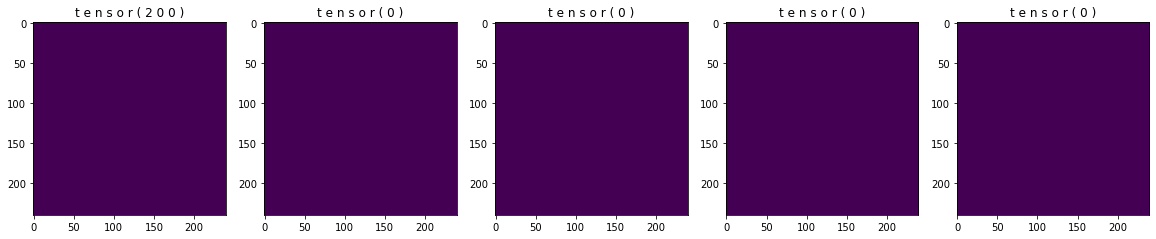

In [5]:
def train_imshow():
    dataiter = iter(train_loader)
    
    images_RGB,images_Depth, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images_RGB[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % labels[i])) #name the image of class value
    plt.show()
    
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images_Depth[i].permute(1, 2, 0)) 
        ax.title.set_text(' '.join('%5s' % labels[i])) #name the image of class value
    plt.show()
train_imshow()

## Net1 structure

In [6]:

# create a complete CNN
model = Net1()
print(model)      

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net1(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=1440, bias=True)
  (fc2): Linear(in_features=2880, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv9): Conv2d(

### Specify Loss Function and Optimizer

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy) for multy class classification
#criterion = nn.CrossEntropyLoss()  #for classification
criterion =torch.nn.HuberLoss(reduction='mean', delta=1.0) #for regression
#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, verbose=True, patience=3)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001,max_lr=0.1,step_size_up=10,step_size_down=10,cycle_momentum =False)
#Setting patience=0 reduces the lr until eps is met.
# specify optimizer
#optimizer =torch.optim.Adagrad(model.parameters(), lr=0.01,lr_decay=0.1)
#optimizer


### Net1 training and evaluation


Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)


In [8]:
# number of epochs to train the model
n_epochs = 150

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data_rgb,data_depth, target in train_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data_rgb,data_depth, target = data_rgb.cuda(), data_depth.cuda(),target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = torch.squeeze(model(data_rgb,data_depth))
        # calculate the batch loss
        loss = criterion(output, target.float()) #target = target.to(torch.float32) when using huber loss function
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)# parameter updates after each batch 
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data_rgb.size(0) #data_rgb.size(0)=batch size ,loss.item() brings loss as value not an object
        #loss.item()=Batch_loss= sum(example losses)/batch size

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data_rgb,data_depth, target in valid_loader:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data_rgb,data_depth, target = data_rgb.cuda(), data_depth.cuda(),target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        #data_depth=data_depth.float()  #converts depth image to float32 instead of int 32 
        output = torch.squeeze(model(data_rgb,data_depth))
        # calculate the batch loss
        loss = criterion(output, target.float())
        # update average validation loss 
        valid_loss += loss.item()*data_rgb.size(0)
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler) #len(train_loader.sampler) is size of training examples
    valid_loss = valid_loss/len(valid_loader.sampler)
    ####################################################
    #Scheduler reduces learning rate if reading is the same 5 readings in a row
    scheduler.step(valid_loss)
    ###################################################
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tLearning rate: {}'.format
          (epoch, train_loss, valid_loss,scheduler.optimizer.param_groups[0]['lr']))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'TestNet1_{}.pt'.format(epoch)) #saves model parameters only
        #torch.save(the_model, PATH)
        valid_loss_min = valid_loss
        

C:\Users\NU\anaconda3\lib\site-packages\torch\nn\modules\loss.py:972: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch: 1 	Training Loss: 35.894085 	Validation Loss: 34.430952 	Learning rate: 0.0001
Validation loss decreased (inf --> 34.430952).  Saving model ...
Epoch: 2 	Training Loss: 35.893480 	Validation Loss: 34.429002 	Learning rate: 0.0001
Validation loss decreased (34.430952 --> 34.429002).  Saving model ...
Epoch: 3 	Training Loss: 35.893381 	Validation Loss: 34.429212 	Learning rate: 0.0001
Epoch: 4 	Training Loss: 35.893564 	Validation Loss: 34.428432 	Learning rate: 0.0001
Validation loss decreased (34.429002 --> 34.428432).  Saving model ...
Epoch     5: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 5 	Training Loss: 35.893942 	Validation Loss: 34.430183 	Learning rate: 2e-05
Epoch: 6 	Training Loss: 35.892926 	Validation Loss: 34.429347 	Learning rate: 2e-05
Epoch: 7 	Training Loss: 35.892073 	Validation Loss: 34.427757 	Learning rate: 2e-05
Validation loss decreased (34.428432 --> 34.427757).  Saving model ...
Epoch: 8 	Training Loss: 35.887177 	Validation Loss: 34.42007

Epoch: 60 	Training Loss: 9.668249 	Validation Loss: 13.411293 	Learning rate: 2e-05
Validation loss decreased (13.586860 --> 13.411293).  Saving model ...
Epoch: 61 	Training Loss: 9.226607 	Validation Loss: 12.803177 	Learning rate: 2e-05
Validation loss decreased (13.411293 --> 12.803177).  Saving model ...
Epoch: 62 	Training Loss: 9.025673 	Validation Loss: 12.991672 	Learning rate: 2e-05
Epoch: 63 	Training Loss: 8.967137 	Validation Loss: 12.561802 	Learning rate: 2e-05
Validation loss decreased (12.803177 --> 12.561802).  Saving model ...
Epoch: 64 	Training Loss: 8.422676 	Validation Loss: 12.784901 	Learning rate: 2e-05
Epoch: 65 	Training Loss: 8.514464 	Validation Loss: 13.225866 	Learning rate: 2e-05
Epoch: 66 	Training Loss: 8.216827 	Validation Loss: 11.898243 	Learning rate: 2e-05
Validation loss decreased (12.561802 --> 11.898243).  Saving model ...
Epoch: 67 	Training Loss: 7.948865 	Validation Loss: 11.651576 	Learning rate: 2e-05
Validation loss decreased (11.898243

Epoch: 122 	Training Loss: 4.291101 	Validation Loss: 8.566306 	Learning rate: 4.000000000000001e-06
Validation loss decreased (8.614054 --> 8.566306).  Saving model ...
Epoch: 123 	Training Loss: 4.251860 	Validation Loss: 8.550961 	Learning rate: 4.000000000000001e-06
Validation loss decreased (8.566306 --> 8.550961).  Saving model ...
Epoch: 124 	Training Loss: 4.253197 	Validation Loss: 8.667241 	Learning rate: 4.000000000000001e-06
Epoch: 125 	Training Loss: 4.237578 	Validation Loss: 8.713089 	Learning rate: 4.000000000000001e-06
Epoch: 126 	Training Loss: 4.188063 	Validation Loss: 8.723114 	Learning rate: 4.000000000000001e-06
Epoch   127: reducing learning rate of group 0 to 8.0000e-07.
Epoch: 127 	Training Loss: 4.203995 	Validation Loss: 8.578102 	Learning rate: 8.000000000000002e-07
Epoch: 128 	Training Loss: 3.963408 	Validation Loss: 8.429325 	Learning rate: 8.000000000000002e-07
Validation loss decreased (8.550961 --> 8.429325).  Saving model ...
Epoch: 129 	Training Los

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])